## Setup

Begin with importing all needed libraries:

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

Next, we are going to source three files and construct two primary data sets.

* The first data set will contain all countries and the GTMI scores they received. This inlcudes the GTEI (Enablement) score and specifically scores related to employee training.
* The second data set will include informaiton about the success of projects completed within the contries.
* The third will include GDP scores, which will be used as an indepenednt variable for reducing Ommitted Variable Bias (OVB).

We start with the GovTech GTMI data.

In [3]:
## GovTech GTMI Scoring Data
# Open Excel data file
#filename = '../Data/WBG_GovTech Dataset_Oct2022.xlsx'
filename = 'Data/WBG_GovTech Dataset_Oct2022.xlsx'
govtech_raw = pd.read_excel(filename, sheet_name = 'CG_GTMI_Data', nrows=396)

# Remove 2020 data rows
govtech_2022 = govtech_raw[govtech_raw.Year == 2022]

# Select columns of interest
govtech = govtech_2022[['Code', 'Economy', 'Population', 'Level', 'Reg', 
                        'Grp', 'GTMI', 'CGSI', 'PSDI', 'DCEI', 'GTEI',
                        'I-45', 'I-45.4', 'I-45.5', 'I-45.5.1', 'I-45.5.3',
                        'I-45.6', 'I-45.7']]

# Rename columns
colnames = {'Economy':'Country', 'Level':'IncomeLevel', 'Reg':'Region',
            'Grp':'Group', 'I-45':'DS_Strategy_Program', 'I-45.4':'FocusArea',
            'I-45.5':'DSProgram', 'I-45.5.1':'DSProgramType', 
            'I-45.5.3':'DSProgramMandatory', 'I-45.6':'DSProgramExternal',
            'I-45.7':'DSProgramPublished'}
govtech = govtech.rename(columns = colnames)

# Show first lines to confirm data
govtech.head()

,Code,Country,Population,IncomeLevel,Region,Group,GTMI,CGSI,PSDI,DCEI,GTEI,DS_Strategy_Program,FocusArea,DSProgram,DSProgramType,DSProgramMandatory,DSProgramExternal,DSProgramPublished
1,AFG,Afghanistan,40099.462,L,SAR,C,0.353608,0.414570,0.546835,0.131361,0.321668,2,1,1,3,1,1,0
3,ALB,Albania,2854.710,UM,ECA,A,0.752084,0.706767,0.857460,0.735200,0.708908,1,3,0,0,0,0,0
5,DZA,Algeria,44177.969,LM,MNA,B,0.501913,0.493249,0.689239,0.309428,0.515738,1,1,1,1,1,2,0
7,AND,Andorra,79.034,H,ECA,C,0.252925,0.195779,0.554948,0.041284,0.219689,0,0,0,0,0,0,0
9,AGO,Angola,34503.774,LM,AFR,C,0.446879,0.435822,0.564652,0.220606,0.566436,1,2,1,2,0,2,2


In [39]:
# Several of the columns get read in as objects instead of numeric.
# Need to convert these to numeric for evaluation.
govtech['DSProgram'] = pd.to_numeric(govtech.DSProgram)
govtech['DSProgramType'] = pd.to_numeric(govtech.DSProgramType)
govtech['DSProgramMandatory'] = pd.to_numeric(govtech.DSProgramMandatory)
govtech['DSProgramExternal'] = pd.to_numeric(govtech.DSProgramExternal)
govtech['DSProgramPublished'] = pd.to_numeric(govtech.DSProgramPublished)
govtech.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 1 to 395
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Code                 198 non-null    object 
 1   Country              198 non-null    object 
 2   Population           198 non-null    float64
 3   IncomeLevel          198 non-null    object 
 4   Region               198 non-null    object 
 5   Group                198 non-null    object 
 6   GTMI                 198 non-null    float64
 7   CGSI                 198 non-null    float64
 8   PSDI                 198 non-null    float64
 9   DCEI                 198 non-null    float64
 10  GTEI                 198 non-null    float64
 11  DS_Strategy_Program  198 non-null    int64  
 12  FocusArea            198 non-null    int64  
 13  DSProgram            198 non-null    int64  
 14  DSProgramType        198 non-null    int64  
 15  DSProgramMandatory   198 non-null    int

Next, we bring in the GovTech projects data, focusing on the project succes rate variables.

In [4]:
## GovTech Projects Data
#filename = '../Data/WBG_DG-GovTech_Projects_Oct2022.xlsx'
filename = 'Data/WBG_DG-GovTech_Projects_Oct2022.xlsx'
projects_raw = pd.read_excel(filename, sheet_name = 'DG Projects', nrows=1449)

# Select columns of interest
projects = projects_raw[['Project ID', 'Region', 'Country', 'ICR Out', 'IEG Out']]
# Rename columns
colnames = {'Project ID':'ProjectID', 'ICR Out':'ICROutcome', 'IEG Out':'IEGOutcome'}
projects = projects.rename(columns = colnames)

# Remove any projects that do not have either an ICR rating or an IEG rating
# Create separate project files
projectsICR = projects[['ProjectID', 'Region', 'Country', 'ICROutcome']]
projectsIEG = projects[['ProjectID', 'Region', 'Country', 'IEGOutcome']]

# Drop missing values form each
projectsICR = projectsICR.dropna()
projectsIEG = projectsIEG.dropna()

# Put them back together with a full outer join
projects = projectsICR.merge(projectsIEG, on=('ProjectID', 'Region', 'Country'),
                                  how='outer', suffixes=('_ICR', '_IEG'))

# Show the first few lines to confirm the data
projects.head()

DG Projects


,ProjectID,Region,Country,ICROutcome,IEGOutcome
0,P006661,LCR,Chile,S,S
1,P078359,ECA,Turkiye,HS,HS
2,P058512,ECA,Bosnia and Herzegovina,S,S
3,P079708,SAR,India,S,S
4,P102398,EAP,Lao People's Democratic Republic,HS,S


Finally, we will bring in the GDP data.

In [5]:
## GDP Data
#filename = '../Data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4770391.csv'
filename = 'Data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4770391.csv'
gdp_raw = pd.read_csv(filename, header=2)

# Select columns of interest
gdp = gdp_raw[['Country Name', 'Country Code', '2021']]
# Rename columns
gdp = gdp.rename(columns={'Country Name':'Country', 'Country Code':'Code', '2021':'GDP2021'})

# Show the first few lines to confirm the data
gdp.head()

,Country,Code,GDP2021
0,Aruba,ABW,3.126019e+09
1,Africa Eastern and Southern,AFE,1.080712e+12
2,Afghanistan,AFG,1.478686e+10
3,Africa Western and Central,AFW,8.401873e+11
4,Angola,AGO,6.740429e+10


## Prep GTMI Data for Analysis
Next, we need to prep the GTMI data for analysis through regression, including Logit regression. Steps we need to complete here, include:
1. Add the GDP data as an additional variable.
2. Convert IncomeLevel to a factor variable to use for OVB.

Ultimately, IncomeLevel, Population, and GDP will all be used as control variables for OVB. The values in GTEI, DS_Strategy_Program, FoucsArea, DSProgram, DSProgramType, DSProgramMandatory, DSProgramExternal, and DSProgramPublished will be used as independent varaibles fo interest in an attemtp to predict the GTMI score. I.e. do these enablement and Tech Skills training bvalues incfluence the overall Tech Maturity of a government.

In [42]:
# Merge the GDP data into the GovTech GTMI data.
govtech_gdp = govtech.merge(gdp, on=('Code'), how='left', suffixes=('', '_gdp'))

# Drop the redundant Country value brought into the data set
govtech_gdp = govtech_gdp.drop(columns=['Country_gdp'])

# Did the merge result in any GTMI countries missing a GDP value?
print(np.mean(govtech_gdp.GDP2021 <= 0))

# Show results
govtech_gdp.head()

0.0


,Code,Country,Population,IncomeLevel,Region,Group,GTMI,CGSI,PSDI,DCEI,GTEI,DS_Strategy_Program,FocusArea,DSProgram,DSProgramType,DSProgramMandatory,DSProgramExternal,DSProgramPublished,GDP2021
0,AFG,Afghanistan,40099.462,L,SAR,C,0.353608,0.414570,0.546835,0.131361,0.321668,2,1,1,3,1,1,0,1.478686e+10
1,ALB,Albania,2854.710,UM,ECA,A,0.752084,0.706767,0.857460,0.735200,0.708908,1,3,0,0,0,0,0,1.825579e+10
2,DZA,Algeria,44177.969,LM,MNA,B,0.501913,0.493249,0.689239,0.309428,0.515738,1,1,1,1,1,2,0,1.630444e+11
3,AND,Andorra,79.034,H,ECA,C,0.252925,0.195779,0.554948,0.041284,0.219689,0,0,0,0,0,0,0,3.330282e+09
4,AGO,Angola,34503.774,LM,AFR,C,0.446879,0.435822,0.564652,0.220606,0.566436,1,2,1,2,0,2,2,6.740429e+10


Now we can convert the IncomeLevel column to a categorical variable to use for reducing OVB.

In [43]:
# Define the categories and corresponding codes
categories = ['L', 'LM', 'UM', 'H']
codes = [0, 1, 2, 3]

# Create a categorical data type to convert the existing variable
from pandas.api.types import CategoricalDtype
cat_dtype = CategoricalDtype(
    categories=['L', 'LM', 'UM', 'H'], ordered=True)

# Convert the IncomeLevel column to categorical
govtech_gdp['IncomeLevel'] = govtech_gdp['IncomeLevel'].astype(cat_dtype)

# Outcome should look no different
print(govtech_gdp['IncomeLevel'].head(10))

# But the type of the column is now categorical
print(type(govtech_gdp.IncomeLevel.array))

0     L
1    UM
2    LM
3     H
4    LM
5     H
6    UM
7    UM
8     H
9     H
Name: IncomeLevel, dtype: category
Categories (4, object): ['L' < 'LM' < 'UM' < 'H']
<class 'pandas.core.arrays.categorical.Categorical'>


The GovTech GTMI data is now ready for regression analysis.

## Prep Projects Data for Analysis
The projects data includes two key varaibles that we want to predict: ICROutcome and IEGOutcome. These are two separate categorical values that are based on independent evaluations of individual technology projects subsidized by the World Bank Group (WBG). We will want to use the same independent predictor variables from the GTMI data to predict project success, i.e. does Tech Skills enablement influence the success of technology projects.

There are a number of challenges with merging the Projects and GovTech GTMI data:
* Not all projects have recorded outcome variables. We already removed projects where neither outcome variable has a value. Where only one is missing, we will assume an unsatisfactory outcome for that variable.
* Outcome variables are currently categorical and will need to be altered to act as binary variables for Logit regression.
* Not all countries have recorded projects from the WBG. These coutnries will need to be removed from the data set.
* We need to include the same independent variables for reducing OVB.
* The projects data has a Country name, but NOT a Coutnry Code. This reduces the matches that we will get, and we will need to provide additional information.

For each Oucome variable, there are 6 possible values: HS, S, MS, MU, U, HU. let's start by getting a perspective of the distribution of the data based on each variable.



In [44]:
projects.head()

,ProjectID,Region,Country,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB
0,P006661,LCR,Chile,S,S,1,1
1,P078359,ECA,Turkiye,HS,HS,1,1
2,P058512,ECA,Bosnia and Herzegovina,S,S,1,1
3,P079708,SAR,India,S,S,1,1
4,P102398,EAP,Lao People's Democratic Republic,HS,S,1,1


Distribution of ICROutcome values

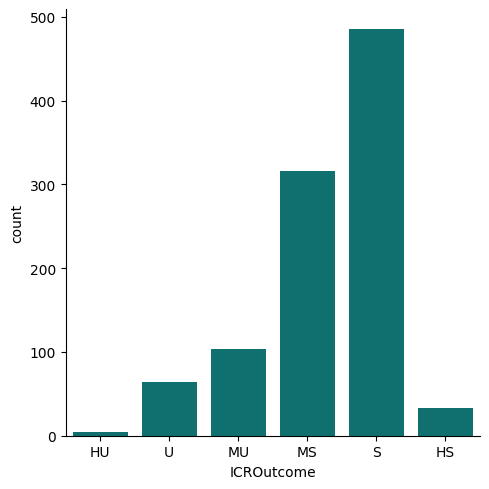

In [9]:
# Distribution of ICROutcome values
category_order = ['HU', 'U', 'MU', 'MS', 'S', 'HS']
sns.catplot(x='ICROutcome', data=projects, kind='count', order=category_order, color='teal')
plt.show()

Distribution of IEGOutcome values

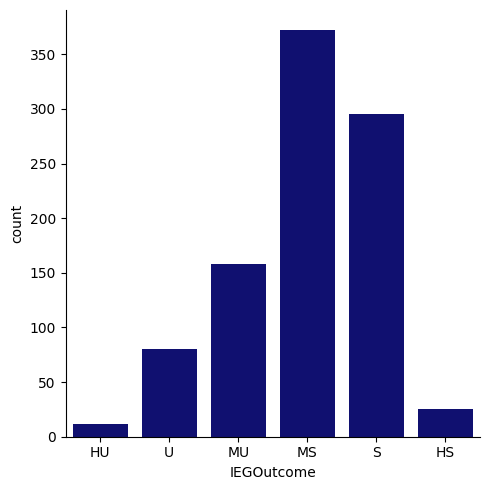

In [10]:
# Distribution of IEGOutcome values
sns.catplot(x='IEGOutcome', data=projects, kind='count', order=category_order, color='navy')
plt.show()

Start by creating binary variables based on any of the three levels of success.

In [11]:
# Create binary values for ICROutcome and IEGOutcome
projects['ICROutcomeB'] = np.where(projects['ICROutcome'].isin(['HS', 'S', 'MS']), 1, 0)
projects['IEGOutcomeB'] = np.where(projects['IEGOutcome'].isin(['HS', 'S', 'MS']), 1, 0)

# Check the totals for each binary variable
print(np.sum(projects.ICROutcomeB))
print(np.sum(projects.IEGOutcomeB))

# Display the first few columns of the data set
projects.head(10)

834
692


,ProjectID,Region,Country,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB
0,P006661,LCR,Chile,S,S,1,1
1,P078359,ECA,Turkiye,HS,HS,1,1
2,P058512,ECA,Bosnia and Herzegovina,S,S,1,1
3,P079708,SAR,India,S,S,1,1
4,P102398,EAP,Lao People's Democratic Republic,HS,S,1,1
5,P144871,ECA,Croatia,MS,MS,1,1
6,P147740,AFR,Cote d'Ivoire,S,MS,1,1
7,P064536,ECA,Bulgaria,S,MS,1,1
8,P038947,LCR,Brazil,S,S,1,1
9,P005741,MNA,Tunisia,S,S,1,1


Now we need to join the project results to the GTMI results. However, we only have a Country name variable in the __projects__ data, not a Country _Code_. We can start by adding Country codes using the _Code_ and _Country_ values from the __govtech__ data, then fill in where we Country names are not matching.

We start by creating a lookup table with Country names and Country Codes from the more complete __govtech__ data set. We can then merge this to our __projects__ data.

In [45]:
# Create a set of Country names and Country Codes from the govtech data.
country_lookup = govtech[['Country', 'Code']]

# Join this to the projects data based on the Country name
projectscd = projects.merge(country_lookup, on='Country', how='left', suffixes=('_prj', '_gt'))

# preview the data
projectscd.head(10)


,ProjectID,Region,Country,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB,Code
0,P006661,LCR,Chile,S,S,1,1,CHL
1,P078359,ECA,Turkiye,HS,HS,1,1,NaN
2,P058512,ECA,Bosnia and Herzegovina,S,S,1,1,BIH
3,P079708,SAR,India,S,S,1,1,IND
4,P102398,EAP,Lao People's Democratic Republic,HS,S,1,1,NaN
5,P144871,ECA,Croatia,MS,MS,1,1,HRV
6,P147740,AFR,Cote d'Ivoire,S,MS,1,1,NaN
7,P064536,ECA,Bulgaria,S,MS,1,1,BGR
8,P038947,LCR,Brazil,S,S,1,1,BRA
9,P005741,MNA,Tunisia,S,S,1,1,TUN


There is a small set of Countries in the __projects__ data that does not match to the country names in the __govtech__ data. There is no easy way to handle this, so our best option is to manually create additional lookup values.

In [46]:
# Which countries did not get picked up?
projectscd[pd.isna(projectscd['Code'])]['Country'].unique()

array(['Turkiye', "Lao People's Democratic Republic", "Cote d'Ivoire",
       'Egypt, Arab Republic of', 'Central Africa', 'Africa',
       'Congo, Democratic Republic of', 'Congo, Republic of',
       'Eastern and Southern Africa', 'Yemen, Republic of',
       'Sao Tome and Principe', 'Gambia, The',
       'Western and Central Africa',
       'Venezuela, Republica Bolivariana de', 'Caribbean',
       'Iran, Islamic Republic of', 'OECS Countries'], dtype=object)

In [47]:
# Manually create a lookup data frame with the additional values
add_lookup = pd.DataFrame({'Country':['Turkiye', 'Lao People\'s Democratic Republic', 'Cote d\'Ivoire',
                                   'Egypt, Arab Republic of', 'Central Africa', 'Africa', 'Congo, Democratic Republic of',
                                   'Congo, Republic of', 'Eastern and Southern Africa', 'Yemen, Republic of',
                                   'Sao Tome and Principe', 'Gambia, The', 'Western and Central Africa',
                                   'Venezuela, Republica Bolivariana de', 'Caribbean', 'Iran, Islamic Republic of',
                                   'OECS Countries'], 
                        'Code':['TUR', 'LAO', 'CIV', 'EGY', 'CAF', 'UNK', 'COD', 'COG', 'UNK', 'YEM', 
                                'STP', 'GMB', 'UNK', 'VEN', 'UNK', 'IRN', 'UNK']})

# Let's add these new values to the original lookup data frame
country_lookup_full = pd.concat([country_lookup, add_lookup])

# Repeat the previous merge effort with the longer list of country codes
projectscd = projects.merge(country_lookup_full, on='Country', how='left', suffixes=('_prj', '_add'))

# Validate we no longer have any missing Codes
print(np.sum(pd.isna(projectscd.Code)))

# preview the data
projectscd.head(10)

0


,ProjectID,Region,Country,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB,Code
0,P006661,LCR,Chile,S,S,1,1,CHL
1,P078359,ECA,Turkiye,HS,HS,1,1,TUR
2,P058512,ECA,Bosnia and Herzegovina,S,S,1,1,BIH
3,P079708,SAR,India,S,S,1,1,IND
4,P102398,EAP,Lao People's Democratic Republic,HS,S,1,1,LAO
5,P144871,ECA,Croatia,MS,MS,1,1,HRV
6,P147740,AFR,Cote d'Ivoire,S,MS,1,1,CIV
7,P064536,ECA,Bulgaria,S,MS,1,1,BGR
8,P038947,LCR,Brazil,S,S,1,1,BRA
9,P005741,MNA,Tunisia,S,S,1,1,TUN


Important to note is that in the manual lookup data, there were some Country names that could not be reconciled. Some of these projects referred to groups of countries, of countries that do not appear in the __govtech__ GTMI data. We labeled these with a _Code_ of 'UNK' for 'Unknown'. Without a clear conuntry to reconcile to, we need to drop these values.

In [48]:
print('Total projects: ' + str(len(projectscd)))
print('Projects with unknown countries: ' + str(np.sum(projectscd.Code == 'UNK')))

# Drop the projects with Unknown country codes
projectscd = projectscd[projectscd['Code'] != 'UNK']
print('Remaining projects: ' + str(len(projectscd)))

Total projects: 1024
Projects with unknown countries: 25
Remaining projects: 999


Our __projectscd__ data now has coutnry codes. This allows us to join the data to out __govtech_gdp__ data, getting important independent variables from which we can then perform logit regression on the two _Outcome_ variables.

In [49]:
# Merge the projects and govtech data
projects_gtmi = projectscd.merge(govtech_gdp, on='Code', how='left', suffixes=('_prj', ''))
# Drop the Region and Country fields from projects in favor of the more complete govtech
projects_gtmi = projects_gtmi.drop(columns=['Region_prj', 'Country_prj'])

# Examine the resulting data set
projects_gtmi


,ProjectID,ICROutcome,IEGOutcome,ICROutcomeB,IEGOutcomeB,Code,Country,Population,IncomeLevel,Region,...,DCEI,GTEI,DS_Strategy_Program,FocusArea,DSProgram,DSProgramType,DSProgramMandatory,DSProgramExternal,DSProgramPublished,GDP2021
0,P006661,S,S,1,1,CHL,Chile,19493.184,H,LCR,...,0.681820,0.728947,2,2,1,2,1,1,0,3.170585e+11
1,P078359,HS,HS,1,1,TUR,Türkiye,84775.404,UM,ECA,...,0.847791,0.846981,2,3,1,2,1,2,1,8.190352e+11
2,P058512,S,S,1,1,BIH,Bosnia and Herzegovina,3270.943,UM,ECA,...,0.159717,0.176278,0,0,0,0,0,0,0,2.336536e+10
3,P079708,S,S,1,1,IND,India,1407563.842,LM,SAR,...,0.954961,0.903784,2,3,1,2,1,2,2,3.176295e+12
4,P102398,HS,S,1,1,LAO,Lao PDR,7425.057,LM,EAP,...,0.432448,0.369742,0,0,0,0,0,0,0,1.882715e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,P006669,NaN,HS,0,1,CHL,Chile,19493.184,H,LCR,...,0.681820,0.728947,2,2,1,2,1,1,0,3.170585e+11
995,P007457,NaN,S,0,1,JAM,Jamaica,2827.695,UM,LCR,...,0.517516,0.421741,1,0,1,1,1,1,0,1.465759e+10
996,P044387,NaN,MS,0,1,ARM,Armenia,2790.974,UM,ECA,...,0.706000,0.630724,0,0,0,0,0,0,0,1.386141e+10
997,P008413,NaN,S,0,1,GEO,Georgia,3757.980,UM,ECA,...,0.499167,0.630316,0,0,0,0,0,0,0,1.862937e+10


## Regression Of GTMI Data
In this first regression analysis, we will perfroman a regression analysis of the GTMI results based on GTEI and the Tech Skills enablement variables used to generate the GTEI variable. The goal is to assess to what extent that Tech Skills enablement influences the overall Tech maturity of a government organization.

Let's start iwth some basic exploration of the variables.

Correlation coefficient: 0.9552107020494737


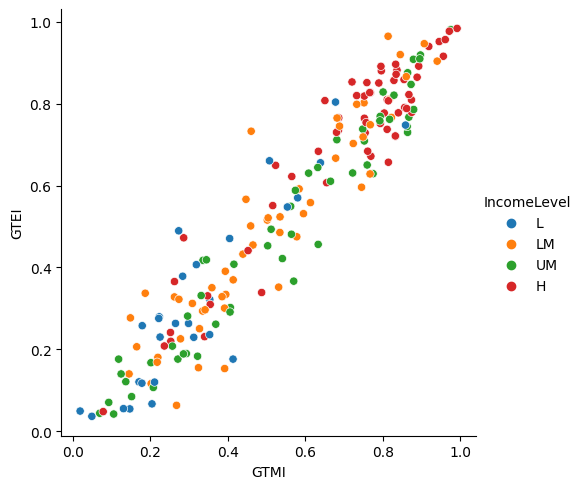

In [50]:
# Correlation between the values
print("Correlation coefficient: " + str(govtech_gdp.GTMI.corr(govtech_gdp.GTEI)))

# Create a scatterplot of GTEI against GTMI with IncomeLevel as color
sns.relplot(x='GTMI', y='GTEI', data=govtech_gdp, kind='scatter', hue='IncomeLevel')
plt.show()

Unsurpisingly, the GTEI data appears strongly correlated with the GTMI score, since GTEI is one of 4 composite scores that are used to generate GTMI. In this plot, however, theinteresting aspect is that IncomeLevel is generally scattered across the values. This indicates that average Income Level may NOT be an influencing factor for Tech Maturity.

Population and GDP are the other two variables we are interested in examining for OVB. First, let's look at the distribution of the two data sets.

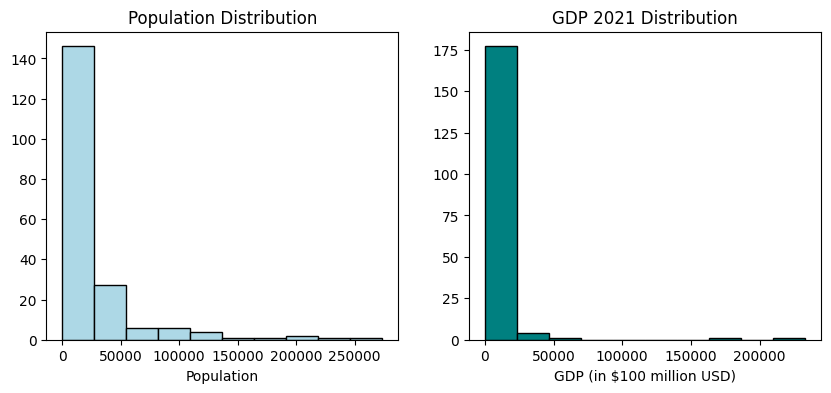

In [51]:
# Start by subsetting just the columns of interest
dfSub = govtech_gdp[['GTMI', 'GTEI', 'Population', 'GDP2021']].copy()
# Population is highly skewed. Let's remove dsome outliers.
dfPopulation = dfSub[dfSub['Population'] <= 300000]
# And for simplicity of understnaidng the data, let's convert GDP to 100s of millions
dfSub['GDPMil'] = dfSub['GDP2021'] / 100000000

# Now plot the distributions of both values
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(dfPopulation['Population'], bins=10, color='lightblue', linewidth=1, edgecolor="black")
ax[0].set_xlabel('Population')
ax[0].set_title('Population Distribution')
ax[1].hist(dfSub['GDPMil'], bins=10, color='teal', linewidth=1, edgecolor="black")
ax[1].set_xlabel('GDP (in $100 million USD)')
ax[1].set_title('GDP 2021 Distribution')
plt.show()

Both distributions are highly skewed. The outliers could definitely affect the otucome of the regression analysis. Instead, let's consider logartimic calculations on both.

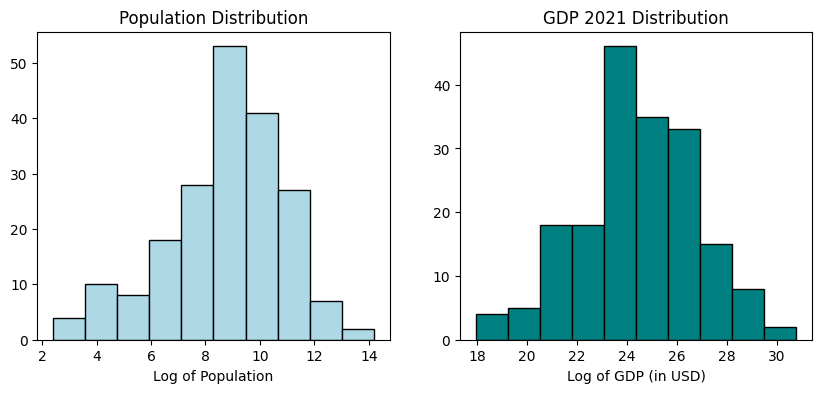

In [52]:
# Calculate logarithmic values for Population and GDP
dfSub['logPopulation'] = np.log(dfSub['Population'])
dfSub['logGDP'] = np.log(dfSub['GDP2021'])

# Replot the distributions based on the logrithmic values
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(dfSub['logPopulation'], bins=10, color='lightblue', linewidth=1, edgecolor="black")
ax[0].set_xlabel('Log of Population')
ax[0].set_title('Population Distribution')
ax[1].hist(dfSub['logGDP'], bins=10, color='teal', linewidth=1, edgecolor="black")
ax[1].set_xlabel('Log of GDP (in USD)')
ax[1].set_title('GDP 2021 Distribution')
plt.show()


These distributions look much more usable. Let's take a look at how they influence the GTMI and GTEI scores through scatterplots similar to what we did with IncomeLevel.

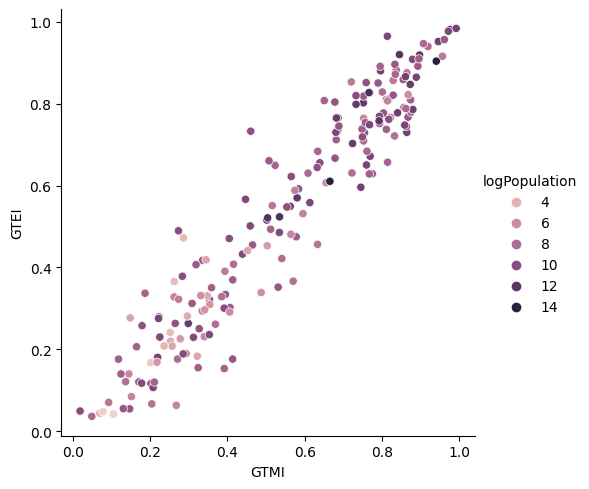

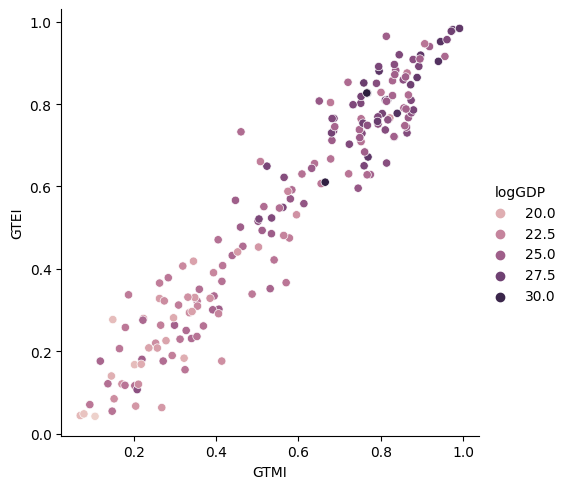

In [53]:
# Create a scatterplot of GTEI against GTMI with log of Population as color
sns.relplot(x='GTMI', y='GTEI', data=dfSub, kind='scatter', hue='logPopulation')
plt.show()

# Create a scatterplot of GTEI against GTMI with log of GDP as color
sns.relplot(x='GTMI', y='GTEI', data=dfSub, kind='scatter', hue='logGDP')
plt.show()

The scatter plots show a slightly increased concentration of higher population and higher GDP in the upper right. However, the concentrations do not appear significant through visual observation. In general, the values are spread throughout the GTMI and GTEI results. Let's add these logistic values to our primary data set.

In [54]:
# Calculate Log of Popualtion and GDP and add as varaibles to the data frame
govtech_gdp['logPopulation'] = np.log(govtech_gdp['Population'])
govtech_gdp['logGDP'] = np.log(govtech_gdp['GDP2021'])

### Correlation of GTMI to Tech Skills Training
Let's start with a simple correlation between GTMI, GTEI, and the other TechSkills enablement variables.

In [55]:

# We are breaking this into two matrices for simplicity in reading

### &&&
columns = ['GTMI', 'GTEI', 'DS_Strategy_Program', 'FocusArea', 'DSProgram', 'DSProgramType']
subset = govtech_gdp[columns].copy()
subset.corr()

,GTMI,GTEI,DS_Strategy_Program,FocusArea,DSProgram,DSProgramType
GTMI,1.000000,0.955211,0.686902,0.642714,0.688991,0.716682
GTEI,0.955211,1.000000,0.753738,0.677207,0.735473,0.742587
DS_Strategy_Program,0.686902,0.753738,1.000000,0.735846,0.763739,0.728100
FocusArea,0.642714,0.677207,0.735846,1.000000,0.687912,0.656290
DSProgram,0.688991,0.735473,0.763739,0.687912,1.000000,0.916313
DSProgramType,0.716682,0.742587,0.728100,0.656290,0.916313,1.000000


In [56]:
# And repeat with the remaining data
columns = ['GTMI', 'GTEI', 'DSProgramMandatory', 'DSProgramExternal', 'DSProgramPublished']
subset = govtech_gdp[columns].copy()
subset.corr()

,GTMI,GTEI,DSProgramMandatory,DSProgramExternal,DSProgramPublished
GTMI,1.000000,0.955211,0.597771,0.656245,0.423575
GTEI,0.955211,1.000000,0.642235,0.698605,0.473223
DSProgramMandatory,0.597771,0.642235,1.000000,0.680191,0.457650
DSProgramExternal,0.656245,0.698605,0.680191,1.000000,0.517175
DSProgramPublished,0.423575,0.473223,0.457650,0.517175,1.000000


Based on the above correlation matrices, it appears the variables with the least correlation with GTMI and GTEI are DSProgramMandatory (indicating whether new employees are required to take the Tech Skills training), and DSProgramPublished (indicating whether the results of the training program are published). We can keep this in mind as we turn to Regression analysis.

### Regression of GTMI on Tech Skills Training
We can start with simple regression.

In [57]:
# Import linregress from SciPy Stats library
from scipy.stats import linregress

# Call a simple regression function with the predictor followed by the dependent variable
model = linregress(govtech_gdp.GTEI, govtech_gdp.GTMI)

# Print results for interpretation
print(f'Intercept: {model.intercept:.4f}')
print(f'GTEI: {model.slope:.4f} ({model.stderr:.4f})')
print(f'R-Value: {model.rvalue:.4f}')
print(f'P-Value: {model.pvalue:.4f}')


Intercept: 0.0668
GTEI: 0.9053 (0.0200)
R-Value: 0.9552
P-Value: 0.0000


In this simple regression model, the GTEI enablement score has a coefficient of 0.9053 (0.02), indicating that a value of 1 for the GTEI score will increase the GTMI score by 0.9053. However, we have to keep in mind that GTEI and GTMI scores have a range of 0 to 1. Therefore, we could interpret this as an increased value of 0.1 in the GTEI score (enablement) improves the overall Tech Maturity of teh GTMI score by 0.09, or almost 0.1, indicating a very near 1 to 1 correlation.

We can illustrate this with our earlier scatterplot and including the regression line.

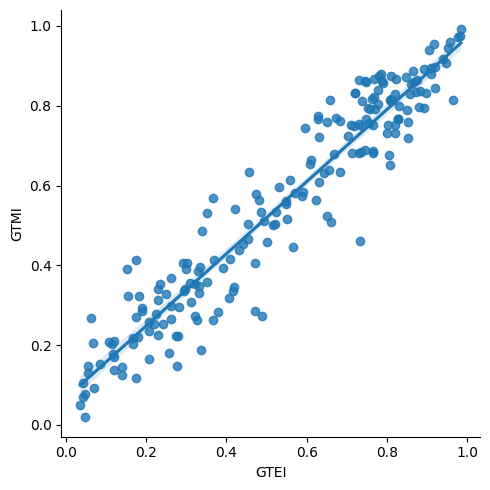

In [58]:
sns.lmplot(data=govtech_gdp, x='GTEI', y='GTMI')

Our next question is does this change significantly if we bring in our independent variables to control for OVB: Income Level, Population, and GDP?

In this case, we are going to leverage statsmodels for more complete linear regression.

In [59]:
# Import statsmodels
import statsmodels.formula.api as smf

In [60]:
# Create dummy variables out of the IncomeLevel categorical variable
dummies=pd.get_dummies(govtech_gdp['IncomeLevel'], prefix='IL', drop_first = True)
# Add the resulting dummies into the larger data set
govtech_gdp['IL_LM'] = dummies['IL_LM']
govtech_gdp['IL_UM'] = dummies['IL_UM']
govtech_gdp['IL_H'] = dummies['IL_H']


In [61]:

# Add in our independent variables to account for OVB, including the dummies created for IncomeLevel
model = smf.ols('GTMI ~ GTEI + logPopulation + logGDP + IL_LM + IL_UM + IL_H', data=govtech_gdp)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GTMI   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     360.3
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           2.12e-96
Time:                        10:56:49   Log-Likelihood:                 227.40
No. Observations:                 184   AIC:                            -440.8
Df Residuals:                     177   BIC:                            -418.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0033      0.153      0.022      0.983      -0.298       0.305
GTEI              0.8576      0.029     29.841      0.000       0.801       0.914
logPopulation     0.0068      0.012      0.590      0.556      -0.016       0.030
logGDP           -0.0002      0.011     -0.022      0.983      -0.022       0.022
IL_LM             0.0201      0.023      0.874      0.383      -0.025       0.066
IL_UM             0.0648      0.033      1.984      0.049       0.000       0.129
IL_H              0.0504      0.048      1.054      0.294      -0.044       0.145
==============================================================================
Omnibus:                        2.431   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.297   Jarque-Bera (JB):                2.246
Skew:                          -0.101   Prob(JB):                        0.325
Kurtosis:                       3.502   Cond. No.                         796.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the output from the above, we see a slightly smaller coeficient for the GTEI score, 0.8576, compared to 0.9053 on the simple regression. This score remains significant with a t-score of 29.8, and an extremely small p-value (5.642e-71). Again, this is nto a surprise, as the GTEI score is one of 4 used to generate the GTMI score.

However, the GTEI score itself is comprised of 56 separate numerical scores, some weighted. Of these, 23 scores fall to the category of _Human Capital_, including the 7 scores we are most interested in, relating to Technical Skills enablement.

With a  baseline regression provided above, we can now examine what influence these individual scores have on a government organization's overall Tech Maturity (GTMI). Note that these Technical Skills variables all have limited values, some binary (0 or 1), and some with only three values (0,1,2 or 1,2,3). For this reason, they can be considered categorical to some extent. As each score is ordered, i.e. the higher the number the higher the level of skills enablement, they can still be used for the regression analysis.

In [62]:
# Build complete regression for GTMI
model = smf.ols('GTMI ~ DS_Strategy_Program + FocusArea + DSProgram + DSProgramType + \
                DSProgramMandatory + DSProgramExternal + DSProgramPublished +\
                logPopulation + logGDP + IL_LM + IL_UM + IL_H',    # Control variables for OVB
                data=govtech_gdp)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GTMI   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     44.21
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           4.36e-46
Time:                        10:57:03   Log-Likelihood:                 119.79
No. Observations:                 184   AIC:                            -213.6
Df Residuals:                     171   BIC:                            -171.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3613      0.285     -1.268      0.206      -0.924       0.201
DS_Strategy_Program     0.0359      0.022      1.603      0.111      -0.008       0.080
FocusArea               0.0267      0.012      2.238      0.027       0.003       0.050
DSProgram              -0.0443      0.058     -0.764      0.446      -0.159       0.070
DSProgramType           0.0634      0.024      2.694      0.008       0.017       0.110
DSProgramMandatory      0.0233      0.023      0.994      0.322      -0.023       0.070
DSProgramExternal       0.0300      0.018      1.714      0.088      -0.005       0.065
DSProgramPublished      0.0215      0.015      1.445      0.150      -0.008       0.051
logPopulation           0.0195      0.022      0.902      0.368      -0.023       0.062
logGDP                  0.0185      0.021      0.878      0.381      -0.023       0.060
IL_LM                   0.0658      0.043      1.532      0.127      -0.019       0.151
IL_UM                   0.1732      0.061      2.844      0.005       0.053       0.293
IL_H                    0.2180      0.090      2.435      0.016       0.041       0.395
==============================================================================
Omnibus:                        0.287   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.866   Jarque-Bera (JB):                0.100
Skew:                          -0.037   Prob(JB):                        0.951
Kurtosis:                       3.087   Cond. No.                         820.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
# Build complete regression for GTEI
model = smf.ols('GTEI ~ DS_Strategy_Program + FocusArea + DSProgram + DSProgramType + \
                DSProgramMandatory + DSProgramExternal + DSProgramPublished +\
                logPopulation + logGDP + IL_LM + IL_UM + IL_H',    # Control variables for OVB
                data=govtech_gdp)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GTEI   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     56.12
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           7.43e-53
Time:                        10:57:14   Log-Likelihood:                 125.88
No. Observations:                 184   AIC:                            -225.8
Df Residuals:                     171   BIC:                            -184.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3848      0.276     -1.396      0.164      -0.929       0.159
DS_Strategy_Program     0.0712      0.022      3.283      0.001       0.028       0.114
FocusArea               0.0203      0.012      1.758      0.080      -0.002       0.043
DSProgram              -0.0351      0.056     -0.625      0.533      -0.146       0.076
DSProgramType           0.0544      0.023      2.391      0.018       0.009       0.099
DSProgramMandatory      0.0262      0.023      1.155      0.250      -0.019       0.071
DSProgramExternal       0.0325      0.017      1.922      0.056      -0.001       0.066
DSProgramPublished      0.0367      0.014      2.550      0.012       0.008       0.065
logPopulation           0.0162      0.021      0.774      0.440      -0.025       0.058
logGDP                  0.0194      0.020      0.955      0.341      -0.021       0.060
IL_LM                   0.0501      0.042      1.206      0.230      -0.032       0.132
IL_UM                   0.1281      0.059      2.174      0.031       0.012       0.244
IL_H                    0.2059      0.087      2.378      0.019       0.035       0.377
==============================================================================
Omnibus:                        0.532   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.766   Jarque-Bera (JB):                0.256
Skew:                          -0.042   Prob(JB):                        0.880
Kurtosis:                       3.163   Cond. No.                         820.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""